In [1]:
import os
import pydicom
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
from skimage import morphology

from pycm import *

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

import scipy as sp

from skimage.feature import canny
from sklearn.cluster import KMeans
from skimage.filters import sobel
from skimage.morphology import watershed

In [4]:
subs = ['MUMC011', 'MUMC013', 'MUMC014', 'MUMC015', 'MUMC016', 'MUMC017', 'MUMC019', 'MUMC020', 'MUMC021', 'MUMC022', 
        'MUMC024', 'MUMC025', 'MUMC026', 'MUMC028', 'MUMC029', 'MUMC030', 'MUMC032', 'MUMC033']
contrasts = ['T1W', 'MPRAGE', 'TOF', 'T2W', 'T1W-PC']
rois = [1, 2, 3, 4, 6]    

int_values = []

for sub in subs: 
    
    con_dir_name = 'F:/Plaque_delin/'+sub+'/'
    sls = []
    for item in os.listdir(con_dir_name):
        con_file_name = os.path.join(con_dir_name, item)
        if os.path.isfile(con_file_name)&('.dcm' in con_file_name):
            con_file_name_parts = item.split('_')
            sls.append(int(con_file_name_parts[2][2:]))
            
    for sl in sls:
        
        con_name = glob.glob('F:/Plaque_delin/'+sub+'/*sl'+ format(sl, '04d') +'*.dcm')[0]
        con_ds = pydicom.read_file(con_name, force = True)
        con_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        con = con_ds.pixel_array
        
        for roi in rois:
            
            sub_int_values = {'roi': roi, 'sub': sub}
            
            mask = (con == roi)
            mask = mask/mask
            
            for contrast in contrasts:
                
                img_name = glob.glob('F:/Plaque/'+sub+'/*'+contrast+'*sl'+ format(sl, '04d') +'*.dcm')[0]
                img_ds = pydicom.read_file(img_name, force = True)
                img_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                img = img_ds.pixel_array
                
                img_max = np.max(img)
                img_min = np.min(img)
                img_norm = (img-img_min)/(img_max-img_min)
                
                img_masked = img_norm*mask
                sub_int_values[contrast] = img_masked[~np.isnan(img_masked)].flatten()
                
            int_values.append(sub_int_values)

C:\Users\e.lavrova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


In [5]:
int_values_df = pd.DataFrame(int_values)

In [7]:
int_points = []

for i in range (len(int_values_df)):
    for j in range (len(int_values_df.iloc[i]['MPRAGE'])):
        int_point = {'roi': str(int_values_df.iloc[i]['roi']), 
                     'MPRAGE': int_values_df.iloc[i]['MPRAGE'][j], 
                     'T1W': int_values_df.iloc[i]['T1W'][j], 
                     'T1W-PC': int_values_df.iloc[i]['T1W-PC'][j], 
                     'T2W': int_values_df.iloc[i]['T2W'][j], 
                     'TOF': int_values_df.iloc[i]['TOF'][j]}
        int_points.append(int_point)

In [8]:
int_points_df = pd.DataFrame(int_points)

In [9]:
conditions = [
    (int_points_df['roi'] == '1'),
    (int_points_df['roi'] == '2'),
    (int_points_df['roi'] == '3'),
    (int_points_df['roi'] == '4'), 
    (int_points_df['roi'] == '6')]
choices = ['lumen', 'vessel wall', 'lipid', 'calcium', 'haemorrhage']
int_points_df['ROI'] = np.select(conditions, choices, default='vessel wall')

In [11]:
int_points_df_wall = int_points_df.loc[int_points_df.roi != '1']

In [75]:
from sklearn import neighbors
from sklearn.neighbors import NearestCentroid, NeighborhoodComponentsAnalysis, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.pipeline import Pipeline

NN_space = np.array(int_points_df_wall[['MPRAGE', 'T1W', 'T1W-PC', 'T2W', 'TOF']].iloc[len(int_points_df_wall)//2:])
NN_y = int_points_df_wall.iloc[len(int_points_df_wall)//2:].roi.values.astype(int)

model = neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance')

model.fit(NN_space, NN_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

C:\Users\e.lavrova\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


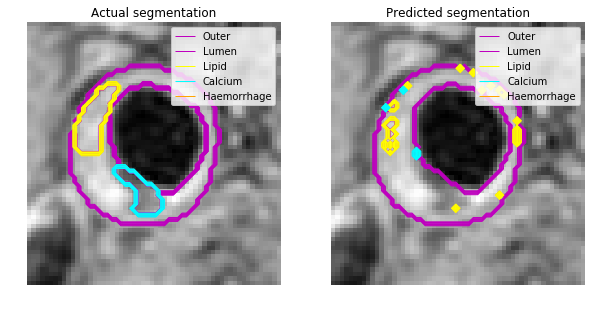

In [76]:
T1W_name = "F:/Plaque/MUMC011/1_T1W_SER_1001_sl0005_ph0001.dcm"
MPRAGE_name = "F:/Plaque/MUMC011/2_MPRAGE_SER_1101_sl0005_ph0001.dcm"
TOF_name = "F:/Plaque/MUMC011/3_TOF_SER_1201_sl0005_ph0001.dcm"
T2W_name = "F:/Plaque/MUMC011/4_T2W_SER_1301_sl0005_ph0001.dcm"
T1WPC_name = "F:/Plaque/MUMC011/5_T1W-PC_SER_1501_sl0005_ph0001.dcm"

con_name = "F:/Plaque_delin/MUMC011/SER_1001_sl0005_ph0001.dcm"
con_ds = pydicom.read_file(con_name, force = True)
con_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
con = con_ds.pixel_array

T1W_ds = pydicom.read_file(T1W_name, force = True)
T1W_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
T1W = T1W_ds.pixel_array

MPRAGE_ds = pydicom.read_file(MPRAGE_name, force = True)
MPRAGE_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
MPRAGE = MPRAGE_ds.pixel_array

TOF_ds = pydicom.read_file(TOF_name, force = True)
TOF_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
TOF = TOF_ds.pixel_array

T2W_ds = pydicom.read_file(T2W_name, force = True)
T2W_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
T2W = T2W_ds.pixel_array

T1WPC_ds = pydicom.read_file(T1WPC_name, force = True)
T1WPC_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
T1WPC = T1WPC_ds.pixel_array

T1W_max = np.max(T1W)
T1W_min = np.min(T1W)
T1W_range = T1W_max - T1W_min

MPRAGE_max = np.max(MPRAGE)
MPRAGE_min = np.min(MPRAGE)
MPRAGE_range = MPRAGE_max - MPRAGE_min

TOF_max = np.max(TOF)
TOF_min = np.min(TOF)
TOF_range = TOF_max - TOF_min

T2W_max = np.max(T2W)
T2W_min = np.min(T2W)
T2W_range = T2W_max - T2W_min

T1WPC_max = np.max(T1WPC)
T1WPC_min = np.min(T1WPC)
T1WPC_range = T1WPC_max - T1WPC_min

T1W_norm = (T1W-T1W_min)/T1W_range
MPRAGE_norm = (MPRAGE-MPRAGE_min)/MPRAGE_range
TOF_norm = (TOF-TOF_min)/TOF_range
T2W_norm = (T2W-T2W_min)/T2W_range
T1WPC_norm = (T1WPC-T1WPC_min)/T1WPC_range

preds = np.zeros(con.shape)

for i,j in zip(np.where(con>0)[0], np.where(con>0)[1]):
    con_pred = model.predict(np.array([MPRAGE_norm[i, j], T1W_norm[i, j], T1WPC_norm[i, j], T2W_norm[i, j], TOF_norm[i, j]]).reshape(1, -1))
    preds[i, j] = con_pred[0]        
        
        
preds_con = preds*(con>1)

xmin = 1
ymin = 1
xmax = con.shape[0]-2
ymax = con.shape[0]-2

xmin = np.min(np.where(con > 0)[0])
xmax = np.max(np.where(con > 0)[0])
ymin = np.min(np.where(con > 0)[1])
ymax = np.max(np.where(con > 0)[1])

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(con[xmin-1:xmax+2, ymin-1:ymax+2], vmin = 0, vmax = 6)
plt.title('Actual segmentation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preds_con[xmin-1:xmax+2, ymin-1:ymax+2], vmin = 0, vmax = 6)
plt.title('Predicted segmentation')
plt.axis('off')

plt.close()

act_vector = []
prd_vector = []

for i,j in zip(np.where(con>0)[0], np.where(con>0)[1]):
        act_vector.append(con[i,j])
        prd_vector.append(int(preds_con[i,j]))

        
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(T1W_norm[xmin-10:xmax+15, ymin-10:ymax+15], cmap = 'gist_gray')
cs2=plt.contour((con == 2)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['m'], linewidths = 1)
cs2.collections[0].set_label('Outer')
cs1=plt.contour((con == 1)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['m'], linewidths = 1)
cs1.collections[0].set_label('Lumen')
cs3=plt.contour((con == 3)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['yellow'], linewidths = 1)
cs3.collections[0].set_label('Lipid')
cs4=plt.contour((con == 4)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['cyan'], linewidths = 1)
cs4.collections[0].set_label('Calcium')
cs6=plt.contour((con == 6)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['orange'], linewidths = 1)
cs6.collections[0].set_label('Haemorrhage')
plt.title('Actual segmentation')
plt.legend()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(T1W_norm[xmin-10:xmax+15, ymin-10:ymax+15], cmap = 'gist_gray')
cs2=plt.contour((preds_con == 2)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['m'], linewidths = 1)
cs2.collections[0].set_label('Outer')
cs1 = plt.contour((preds_con==1)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['m'], linewidths = 1)
cs1.collections[0].set_label('Lumen')
cs3=plt.contour((preds_con == 3)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['yellow'], linewidths = 1)
cs3.collections[0].set_label('Lipid')
cs4=plt.contour((preds_con == 4)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['cyan'], linewidths = 1)
cs4.collections[0].set_label('Calcium')
cs6=plt.contour((preds_con == 6)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['orange'], linewidths = 1)
cs6.collections[0].set_label('Haemorrhage')
plt.title('Predicted segmentation')
plt.legend()
plt.axis('off')

plt.show()

#cm = ConfusionMatrix(actual_vector=act_vector, predict_vector=prd_vector)
#print(cm)   

In [ ]:
subs = ['MUMC011', 'MUMC013', 'MUMC014', 'MUMC015', 'MUMC016', 'MUMC017', 'MUMC019', 'MUMC020', 'MUMC021', 'MUMC022', 
        'MUMC024', 'MUMC025', 'MUMC026', 'MUMC028', 'MUMC029', 'MUMC030', 'MUMC032', 'MUMC033']
contrasts = ['T1W', 'MPRAGE', 'TOF', 'T2W', 'T1W-PC']
rois = [1, 2, 3, 4, 6]    

accs = []

for sub in subs[:6]: 
    
    con_dir_name = 'F:/Plaque_delin/'+sub+'/'
    sls = []
    for item in os.listdir(con_dir_name):
        con_file_name = os.path.join(con_dir_name, item)
        if os.path.isfile(con_file_name)&('.dcm' in con_file_name):
            con_file_name_parts = item.split('_')
            sls.append(int(con_file_name_parts[2][2:]))
            
    for sl in sls:
        
        con_name = glob.glob('F:/Plaque_delin/'+sub+'/*sl'+ format(sl, '04d') +'*.dcm')[0]
        con_ds = pydicom.read_file(con_name, force = True)
        con_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        con = con_ds.pixel_array
        
        T1W_name = glob.glob('F:/Plaque/'+sub+'/*'+'T1W'+'*sl'+ format(sl, '04d') +'*.dcm')[0]
        T1W_ds = pydicom.read_file(T1W_name, force = True)
        T1W_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        T1W = T1W_ds.pixel_array    
        T1W_max = np.max(T1W)
        T1W_min = np.min(T1W)
        T1W_norm = (T1W-T1W_min)/(T1W_max-T1W_min)
        
        T2W_name = glob.glob('F:/Plaque/'+sub+'/*'+'T2W'+'*sl'+ format(sl, '04d') +'*.dcm')[0]
        T2W_ds = pydicom.read_file(T2W_name, force = True)
        T2W_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        T2W = T2W_ds.pixel_array    
        T2W_max = np.max(T2W)
        T2W_min = np.min(T2W)
        T2W_norm = (T2W-T2W_min)/(T2W_max-T2W_min)
        
        TOF_name = glob.glob('F:/Plaque/'+sub+'/*'+'TOF'+'*sl'+ format(sl, '04d') +'*.dcm')[0]
        TOF_ds = pydicom.read_file(TOF_name, force = True)
        TOF_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        TOF = TOF_ds.pixel_array    
        TOF_max = np.max(TOF)
        TOF_min = np.min(TOF)
        TOF_norm = (TOF-TOF_min)/(TOF_max-TOF_min)
        
        T1WPC_name = glob.glob('F:/Plaque/'+sub+'/*'+'T1W-PC'+'*sl'+ format(sl, '04d') +'*.dcm')[0]
        T1WPC_ds = pydicom.read_file(T1WPC_name, force = True)
        T1WPC_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        T1WPC = T1WPC_ds.pixel_array    
        T1WPC_max = np.max(T1WPC)
        T1WPC_min = np.min(T1WPC)
        T1WPC_norm = (T1WPC-T1WPC_min)/(T1WPC_max-T1WPC_min)
        
        MPRAGE_name = glob.glob('F:/Plaque/'+sub+'/*'+'MPRAGE'+'*sl'+ format(sl, '04d') +'*.dcm')[0]
        MPRAGE_ds = pydicom.read_file(MPRAGE_name, force = True)
        MPRAGE_ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        MPRAGE = MPRAGE_ds.pixel_array    
        MPRAGE_max = np.max(MPRAGE)
        MPRAGE_min = np.min(MPRAGE)
        MPRAGE_norm = (MPRAGE-MPRAGE_min)/(MPRAGE_max-MPRAGE_min)
        
        preds = np.zeros(con.shape)

        for i in range (0, con.shape[0]):
            for j in range (0, con.shape[1]):
                con_pred = model_NN.predict(np.array([MPRAGE_norm[i, j], T1W_norm[i, j], 
                                                      T1WPC_norm[i, j], T2W_norm[i, j], TOF_norm[i, j]]).reshape(1, -1))
                preds[i, j] = con_pred[0]

        preds_con = preds*(con>0)
        
        act_vector = []
        prd_vector = []

        for i,j in zip(np.where(con>0)[0], np.where(con>0)[1]):
            act_vector.append(con[i,j])
            prd_vector.append(int(preds_con[i,j]))


        cm = ConfusionMatrix(actual_vector=act_vector, predict_vector=prd_vector)
        accs.append(cm.Overall_ACC)       

        xmin = 1
        ymin = 1
        xmax = con.shape[0]-2
        ymax = con.shape[0]-2

        xmin = np.min(np.where(con > 0)[0])
        xmax = np.max(np.where(con > 0)[0])
        ymin = np.min(np.where(con > 0)[1])
        ymax = np.max(np.where(con > 0)[1])

        fig = plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(T1W_norm[xmin-10:xmax+15, ymin-10:ymax+15], cmap = 'gist_gray')
        cs2=plt.contour((con == 2)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['m'], linewidths = 1)
        cs2.collections[0].set_label('Outer')
        cs1=plt.contour((con == 1)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['r'], linewidths = 1)
        cs1.collections[0].set_label('Lumen')
        cs3=plt.contour((con == 3)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['yellow'], linewidths = 1)
        cs3.collections[0].set_label('Lipid')
        cs4=plt.contour((con == 4)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['cyan'], linewidths = 1)
        cs4.collections[0].set_label('Calcium')
        cs6=plt.contour((con == 6)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['orange'], linewidths = 1)
        cs6.collections[0].set_label('Haemorrhage')
        plt.title('Actual segmentation')
        plt.legend()
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(T1W_norm[xmin-10:xmax+15, ymin-10:ymax+15], cmap = 'gist_gray')
        cs2=plt.contour((preds_con == 2)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['m'], linewidths = 1)
        cs2.collections[0].set_label('Outer')
        cs1 = plt.contour((preds_con==1)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['r'], linewidths = 1)
        cs1.collections[0].set_label('Lumen')
        cs3=plt.contour((preds_con == 3)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['yellow'], linewidths = 1)
        cs3.collections[0].set_label('Lipid')
        cs4=plt.contour((preds_con == 4)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['cyan'], linewidths = 1)
        cs4.collections[0].set_label('Calcium')
        cs6=plt.contour((preds_con == 6)[xmin-10:xmax+15, ymin-10:ymax+15], colors = ['orange'], linewidths = 1)
        cs6.collections[0].set_label('Haemorrhage')
        plt.title('Predicted segmentation')
        plt.legend()
        plt.axis('off')

        fig.suptitle('Vessel components segmentation (Overall acc {})'.format(cm.Overall_ACC))


        plt.savefig('F:/plaque_seg_res/'+sub+'_'+str(sl)+'.png')
        plt.close()
        
        print (sub, sl)